In [13]:
import pandas as pd
import numpy as np
import sys
sys.path.append('e:/PythonProjects/AlgoGameSim')

from agent import Agent, CulturalEnum
from content import Content
from logic import compute_base_match_df

import matplotlib.pyplot as plt

In [14]:
# Generate 100 random agents
num_agents = 100
agents = []

for i in range(num_agents):
    agent = Agent(
        education=np.random.randint(1, 6),
        economic_status=np.random.uniform(10000, 500000),
        ethics=np.random.uniform(0, 1),
        politics=np.random.randint(-2, 3),
        cultural=np.random.choice(list(CulturalEnum)),
        age=np.random.randint(5, 91),
        sex=np.random.randint(0, 2),
        novelty=np.random.uniform(0, 1),
        conscientiousness=np.random.uniform(0, 1),
        impulsivity=np.random.uniform(0, 1),
        tech_affinity=np.random.uniform(0, 1),
        social_trust=np.random.uniform(0, 1)
    )
    agents.append(agent)

# Create DataFrame from agents
agents_data = [agent.to_dict() for agent in agents]
df_agents = pd.DataFrame(agents_data)

# Create tiered income column (5 tiers mapped to 0..1) based on agents' min/max
num_tiers = 5
min_inc = pd.to_numeric(df_agents['economic_status'], errors='coerce').min()
max_inc = pd.to_numeric(df_agents['economic_status'], errors='coerce').max()

def _map_to_tier(v):
    try:
        val = pd.to_numeric(v, errors='coerce')
    except Exception:
        return np.nan
    if pd.isna(val) or pd.isna(min_inc) or pd.isna(max_inc) or max_inc == min_inc:
        return np.nan
    frac = (val - min_inc) / (max_inc - min_inc)
    frac_clipped = max(0.0, min(1.0, frac))
    tier_idx = int(round(frac_clipped * (num_tiers - 1)))
    return tier_idx / (num_tiers - 1)

df_agents['tiered_income'] = df_agents['economic_status'].apply(_map_to_tier)

# Normalize politics to 0..1 and add `normalized_pol` column
def _normalize_politics(val):
    try:
        v = pd.to_numeric(val, errors='coerce')
    except Exception:
        return np.nan
    if pd.isna(v):
        return np.nan
    return (v + 2.0) / 4.0

df_agents['normalized_pol'] = df_agents['politics'].apply(_normalize_politics)

# Show result
df_agents.head()

,agent_id,education,economic_status,ethics,politics,cultural,age,sex,novelty,conscientiousness,impulsivity,tech_affinity,social_trust,tiered_income,normalized_pol
0,1e001e77-f4b5-4153-80ee-8cbad781e0b8,5,50000,0.777540,-1,western,15,0,0.695157,0.595872,0.679655,0.041276,0.393560,0.00,0.25
1,82565398-4681-4a6a-b37d-548a8d5eac9a,3,310000,0.267312,-1,african,21,0,0.244365,0.871594,0.497333,0.517703,0.887983,0.50,0.25
2,edf1deb2-9332-47e5-aad1-219c65816c18,3,155000,0.627662,-1,indigenous,78,1,0.557575,0.797929,0.015750,0.524258,0.230470,0.25,0.25
3,9a4f7533-efd6-4c6e-926d-5cf72df2c33c,4,40000,0.377473,0,african,56,0,0.798722,0.791052,0.725730,0.207627,0.122921,0.00,0.50
4,46178664-8581-47a0-a2cf-93f1c8439c66,2,215000,0.240151,1,indigenous,25,0,0.677212,0.846181,0.164957,0.180005,0.135190,0.50,0.75


In [ ]:
# Create a single Content instance with only selected fields
value_econ = np.random.uniform(10000, 500000)
content = Content(
    economic_status=value_econ,
    ethics = np.random.uniform(0,1),
    novelty = np.random.uniform(0, 1),
    politics = np.random.randint(-2, 2),
    conscientiousness=np.random.uniform(0, 1),
    impulsivity=np.random.uniform(0, 1)
)

# Store in a DataFrame
df_content = pd.DataFrame([content.to_dict()])

# Assign tiered_income to content using the same mapping from df_agents
if 'economic_status' in df_content.columns:
    df_content['tiered_income'] = df_content['economic_status'].apply(_map_to_tier)
else:
    df_content['tiered_income'] = np.nan

# Ensure content mapping includes normalized_pol (compute from politics if needed)
if 'politics' in df_content.columns:
    df_content['normalized_pol'] = df_content['politics'].apply(lambda p: (pd.to_numeric(p, errors='coerce') + 2.0) / 4.0)
else:
    df_content['normalized_pol'] = np.nan

df_content

,content_id,education,economic_status,ethics,politics,cultural,age,sex,novelty,conscientiousness,impulsivity,tech_affinity,social_trust,tiered_income,normalized_pol
0,e1439099-d8da-499b-9300-7fd9ab20434f,None,490000,0.957395,1,None,None,None,0.364421,0.445019,0.132147,None,None,1.0,0.75


In [16]:
# Use the first (and only) row of df_content as the content mapping
content_map = df_content.iloc[0].to_dict()

# Compute base match scores between all agents and this content instance
df_with_scores = compute_base_match_df(df_agents, content_map)

df_with_scores

,agent_id,education,economic_status,ethics,politics,cultural,age,sex,novelty,conscientiousness,...,social_trust,tiered_income,normalized_pol,diff_tiered_income,diff_ethics,diff_normalized_pol,diff_age,diff_sex,diff_cultural,base_score
0,1e001e77-f4b5-4153-80ee-8cbad781e0b8,5,50000,0.777540,-1,western,15,0,0.695157,0.595872,...,0.393560,0.00,0.25,1.00,0.179855,0.50,NaN,NaN,NaN,0.440048
1,82565398-4681-4a6a-b37d-548a8d5eac9a,3,310000,0.267312,-1,african,21,0,0.244365,0.871594,...,0.887983,0.50,0.25,0.50,0.690082,0.50,NaN,NaN,NaN,0.436639
2,edf1deb2-9332-47e5-aad1-219c65816c18,3,155000,0.627662,-1,indigenous,78,1,0.557575,0.797929,...,0.230470,0.25,0.25,0.75,0.329732,0.50,NaN,NaN,NaN,0.473423
3,9a4f7533-efd6-4c6e-926d-5cf72df2c33c,4,40000,0.377473,0,african,56,0,0.798722,0.791052,...,0.122921,0.00,0.50,1.00,0.579922,0.25,NaN,NaN,NaN,0.390026
4,46178664-8581-47a0-a2cf-93f1c8439c66,2,215000,0.240151,1,indigenous,25,0,0.677212,0.846181,...,0.135190,0.50,0.75,0.50,0.717244,0.00,NaN,NaN,NaN,0.594252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0ba0ee79-bc33-4f81-9475-0449158aa569,3,345000,0.822751,1,eastern,62,1,0.248528,0.715190,...,0.451220,0.75,0.75,0.25,0.134644,0.00,NaN,NaN,NaN,0.871785
96,ac9a450f-224b-4cc9-a587-116062225291,2,400000,0.163958,-1,eastern,88,1,0.195498,0.052224,...,0.032924,0.75,0.25,0.25,0.793436,0.50,NaN,NaN,NaN,0.485521
97,6ba34dca-303b-44ab-96e6-4e89b41d101a,1,125000,0.916458,0,western,59,0,0.290102,0.298894,...,0.281436,0.25,0.50,0.75,0.040937,0.25,NaN,NaN,NaN,0.653021
98,00fc7826-f570-40a5-9dc3-298392fa4d2d,4,180000,0.089966,2,multicultural,83,1,0.738861,0.993927,...,0.850137,0.25,1.00,0.75,0.867429,0.25,NaN,NaN,NaN,0.377524


C:\Users\Tim\AppData\Local\Temp\ipykernel_27968\1101657204.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=0)


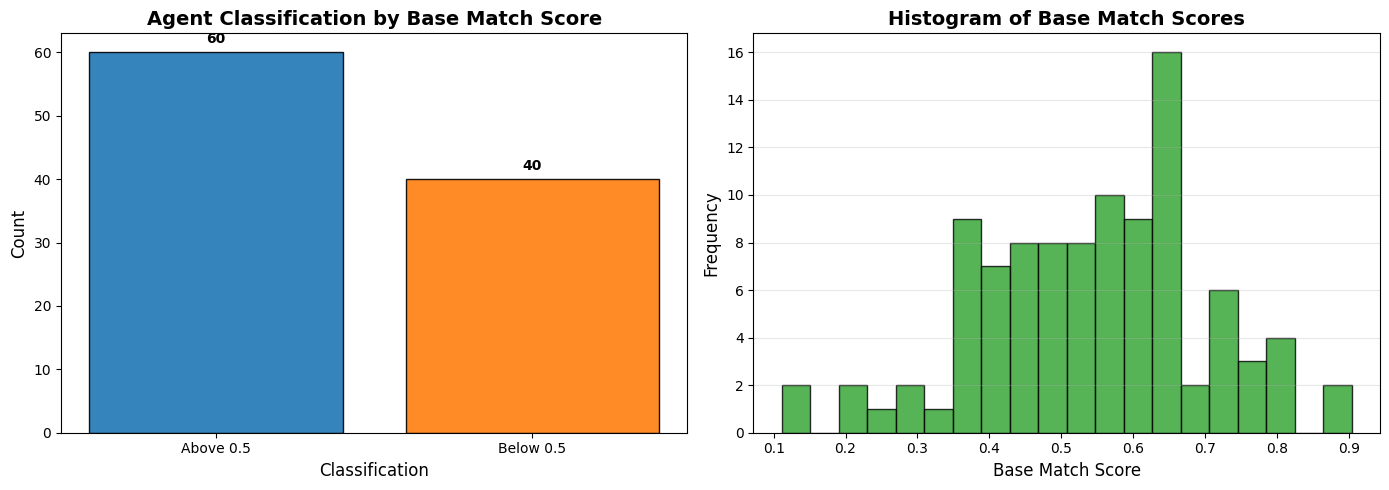

In [17]:
# Classify agents by base_score threshold (0.5)
df_with_scores['base_match_class'] = df_with_scores['base_score'].apply(
    lambda x: 'Above 0.5' if x >= 0.5 else 'Below 0.5'
)

# Count agents in each class (preserve order)
labels = ['Above 0.5', 'Below 0.5']
class_counts_series = df_with_scores['base_match_class'].value_counts()
counts = [int(class_counts_series.get(l, 0)) for l in labels]

# Create side-by-side plots: bar chart + histogram of base_score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart of classification counts
axes[0].bar(labels, counts, color=['#1f77b4', '#ff7f0e'], edgecolor='black', alpha=0.9)
axes[0].set_title('Agent Classification by Base Match Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classification', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(labels, rotation=0)
for i, v in enumerate(counts):
    axes[0].text(i, v + max(1, int(max(counts) * 0.01)), str(v), ha='center', va='bottom', fontweight='bold')

# Right: Histogram of base_score values
base_scores = df_with_scores['base_score'].dropna()
axes[1].hist(base_scores, bins=20, color='#2ca02c', edgecolor='black', alpha=0.8)
axes[1].set_title('Histogram of Base Match Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Base Match Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



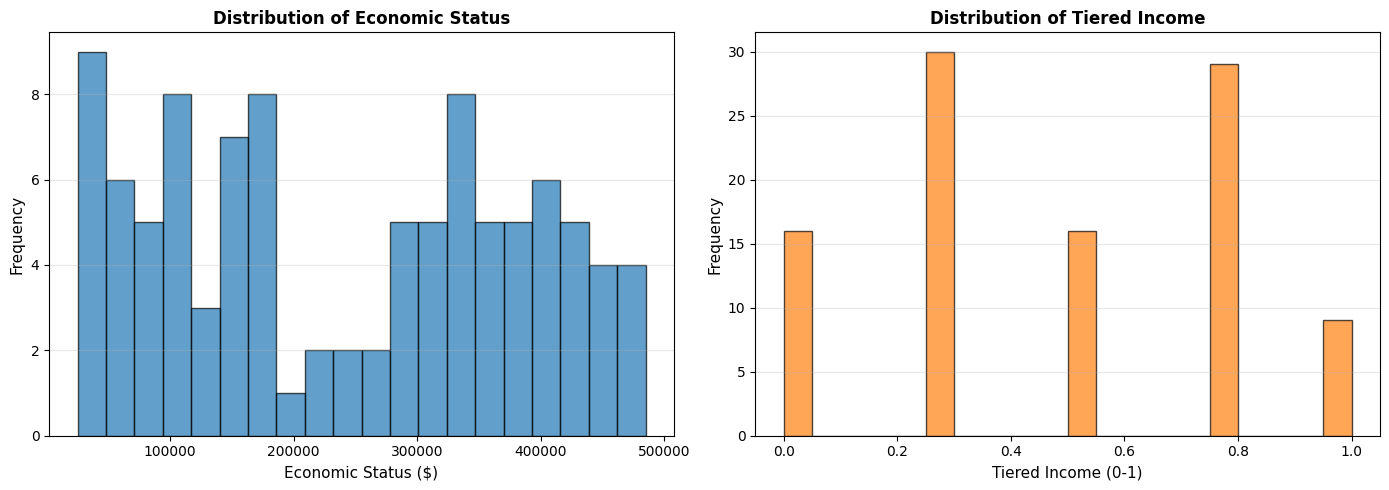

Economic Status Summary:
count       100.000000
mean     240400.000000
std      142191.860711
min       25000.000000
25%      103750.000000
50%      247500.000000
75%      361250.000000
max      485000.000000
Name: economic_status, dtype: float64

Tiered Income Summary:
count    100.000000
mean       0.462500
std        0.314576
min        0.000000
25%        0.250000
50%        0.500000
75%        0.750000
max        1.000000
Name: tiered_income, dtype: float64


In [18]:
# Create two histograms: economic_status and tiered_income distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram 1: Economic Status
axes[0].hist(df_agents['economic_status'], bins=20, color='#1f77b4', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Economic Status', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Economic Status ($)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Histogram 2: Tiered Income
axes[1].hist(df_agents['tiered_income'], bins=20, color='#ff7f0e', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Tiered Income', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tiered Income (0-1)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Economic Status Summary:")
print(df_agents['economic_status'].describe())
print("\nTiered Income Summary:")
print(df_agents['tiered_income'].describe())
